<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/RFM_%26_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import numpy as np

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Online Retail (1).xlsx to Online Retail (1).xlsx


In [4]:
df = pd.read_excel("Online Retail (1).xlsx")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


We have all the crucial information we need:
- Customer ID
- Unit Price
- Quantity
- Invoice Date

With all these features, we can build our equation: Monetary = Active Customer Count * Order Count * Average Revenue per Order

In [5]:
#converting the type of Invoice Date Field from string to datetime.
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#creating YearMonth field for the ease of reporting and visualization
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)

#calculate Monetary for each row and create a new dataframe with YearMonth - Monetary columns
df['Monetary'] = df['Price'] * df['Quantity']

monetary = df.groupby(['InvoiceYearMonth'])['Monetary'].sum().reset_index()
monetary


,InvoiceYearMonth,Monetary
0,201012,748957.020
1,201101,560000.260
2,201102,498062.650
3,201103,683267.080
4,201104,493207.121
5,201105,723333.510
6,201106,691123.120
7,201107,681300.111
8,201108,682680.510
9,201109,1019687.622


### Monthly Active Customers
To see the details Monthly Active Customers, we will follow the steps we exactly did for Monthly Revenue. Starting from this part, we will be focusing on UK data only (which has the most records). We can get the monthly active customers by counting unique CustomerIDs. Code snippet and the output are as follows:

In [6]:
#creating a new dataframe with UK customers only
uk = df.query("Country=='United Kingdom'").reset_index(drop=True)

#creating monthly active customers dataframe by counting unique Customer IDs
monthly_active = uk.groupby('InvoiceYearMonth')['CustomerID'].nunique().reset_index()

#print the dataframe
monthly_active

,InvoiceYearMonth,CustomerID
0,201012,871
1,201101,684
2,201102,714
3,201103,923
4,201104,817
5,201105,985
6,201106,943
7,201107,899
8,201108,867
9,201109,1177


In April, Monthly Active Customer number dropped to 817 from 923 (-11.5%).
We will see the same trend for number of orders as well.
### Monthly Order Count
We will apply the same code by using Quantity field:

In [7]:
#create a new dataframe for no. of order by using quantity field
monthly_sales = uk.groupby('InvoiceYearMonth')['Quantity'].sum().reset_index()

#print the dataframe
monthly_sales

,InvoiceYearMonth,Quantity
0,201012,298101
1,201101,237381
2,201102,225641
3,201103,279843
4,201104,257666
5,201105,306452
6,201106,258522
7,201107,324129
8,201108,319804
9,201109,458490


As we expected, Order Count is also declined in April (279k to 257k, -8%)
We know that Active Customer Count directly affected Order Count decrease. At the end, we should definitely check our Average Revenue per Order as well.
### Average Revenue per Order
To get this data, we need to calculate the average of revenue for each month:

In [8]:
# create a new dataframe for average revenue by taking the mean of it
monthly_order_avg = uk.groupby('InvoiceYearMonth')['Monetary'].mean().reset_index()

#print the dataframe
monthly_order_avg

,InvoiceYearMonth,Monetary
0,201012,16.865860
1,201101,13.614680
2,201102,16.093027
3,201103,16.716166
4,201104,15.773380
5,201105,17.713823
6,201106,16.714748
7,201107,15.723497
8,201108,17.315899
9,201109,18.931723


Even the monthly order average dropped for April (16.7 to 15.8). We observed slow-down in every metric affecting our North Star.
We have looked at our major metrics. Of course there are many more and it varies across industries. Let’s continue investigating some other important metrics:
- New Customer Ratio: a good indicator of if we are losing our existing customers or unable to attract new ones
- Retention Rate: King of the metrics. Indicates how many customers we retain over specific time window. We will be showing examples for monthly retention rate and cohort based retention rate.

### New Customer Ratio
First we should define what is a new customer. In our dataset, we can assume a new customer is whoever did his/her first purchase in the time window we defined. We will do it monthly for this example.
We will be using .min() function to find our first purchase date for each customer and define new customers based on that. The code below will apply this function and show us the revenue breakdown for each group monthly.

In [9]:
#create a dataframe contaning CustomerID and first purchase date
min_purchase = uk.groupby('CustomerID').InvoiceDate.min().reset_index()
min_purchase.columns = ['CustomerID','MinPurchaseDate']
min_purchase['MinPurchaseYearMonth'] = min_purchase['MinPurchaseDate'].map(lambda date: 100*date.year + date.month)

#merge first purchase date column to our main dataframe (tx_uk)
uk = pd.merge(uk, min_purchase, on='CustomerID')
uk.head()

#create a column called User Type and assign Existing if User's First Purchase Year Month before the selected Invoice Year Month
uk['UserType'] = 'New'
uk.loc[uk['InvoiceYearMonth'] > uk['MinPurchaseYearMonth'],'UserType'] = 'Existing'

#calculate the Revenue per month for each user type
user_type_monetary = uk.groupby(['InvoiceYearMonth','UserType'])['Monetary'].sum().reset_index()


In [10]:
uk.head() # Dataframe output after merging with First Purchase Date:

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,InvoiceYearMonth,Monetary,MinPurchaseDate,MinPurchaseYearMonth,UserType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30,2010-12-01 08:26:00,201012,New
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00,2010-12-01 08:26:00,201012,New
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New


In [11]:
user_type_monetary.query('InvoiceYearMonth ! = 201012 and InvoiceYearMonth ! = 201112')

,InvoiceYearMonth,UserType,Monetary
1,201101,Existing,195275.510
2,201101,New,156705.770
3,201102,Existing,220994.630
4,201102,New,127859.000
5,201103,Existing,296350.030
6,201103,New,160567.840
7,201104,Existing,268226.660
8,201104,New,108517.751
9,201105,Existing,434725.860
10,201105,New,90847.490


Existing customers are showing a positive trend and tell us that our customer base is growing but new customers have a slight negative trend.


In [12]:
#create a dataframe that shows new user ratio; drop NA values (first month new user ratio is 0)
user_ratio = uk.query("UserType == 'New'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique() / uk.query("UserType == 'Existing'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique() 
user_ratio = user_ratio.reset_index()
user_ratio = user_ratio.dropna()
user_ratio

,InvoiceYearMonth,CustomerID
1,201101,1.124224
2,201102,0.904000
3,201103,0.792233
4,201104,0.510166
5,201105,0.343793
6,201106,0.281250
7,201107,0.236589
8,201108,0.192572
9,201109,0.304878
10,201110,0.328852


New Customer Ratio has declined as expected (we assumed on Feb, all customers were New) and running around 20%.
### Monthly Retention Rate
Retention rate should be monitored very closely because it indicates how sticky is your service and how well your product fits the market. 

For making Monthly Retention Rate visualized, we need to calculate how many customers retained from previous month.

Monthly Retention Rate = Retained Customers From Prev. Month/Active Customers Total

We will be using crosstab() function of pandas which makes calculating Retention Rate super easy.

In [13]:
#identify which users are active by looking at their revenue per month
user_purchase = uk.groupby(['CustomerID','InvoiceYearMonth'])['Monetary'].sum().reset_index()

#create retention matrix with crosstab
retention = pd.crosstab(user_purchase['CustomerID'], user_purchase['InvoiceYearMonth']).reset_index()
retention.head()

#create an array of dictionary which keeps Retained & Total User count for each month
months = retention.columns[2:]
retention_array = []

for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = int(selected_month)
    retention_data['TotalUserCount'] = retention[selected_month].sum()
    retention_data['RetainedUserCount'] = retention[(retention[selected_month] > 0) & (retention[prev_month] > 0)][selected_month].sum()
    retention_array.append(retention_data)



In [14]:
#convert the array to dataframe and calculate Retention Rate
retention = pd.DataFrame(retention_array)
retention['RetentionRate'] = retention['RetainedUserCount'] / retention['TotalUserCount']
retention

,InvoiceYearMonth,TotalUserCount,RetainedUserCount,RetentionRate
0,201102,714,263,0.368347
1,201103,923,305,0.330444
2,201104,817,310,0.379437
3,201105,985,369,0.374619
4,201106,943,417,0.442206
5,201107,899,379,0.421580
6,201108,867,391,0.450980
7,201109,1177,417,0.354291
8,201110,1285,502,0.390661
9,201111,1548,616,0.397933


In [15]:
# dataframe that shows total monthly revenue for each customer
user_purchase = uk.groupby(['CustomerID', 'InvoiceYearMonth'])['Monetary'].sum().astype(int).reset_index()
user_purchase.head()

,CustomerID,InvoiceYearMonth,Monetary
0,12346.0,201101,0
1,12747.0,201012,706
2,12747.0,201101,303
3,12747.0,201103,310
4,12747.0,201105,771


In [16]:
#crosstab() to covert to retention table
retention = pd.crosstab(user_purchase['CustomerID'], user_purchase['InvoiceYearMonth']).reset_index()
retention.head()

InvoiceYearMonth,CustomerID,201012,201101,201102,201103,201104,201105,201106,201107,201108,201109,201110,201111,201112
0,12346.0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,12747.0,1,1,0,1,0,1,1,0,1,0,1,1,1
2,12748.0,1,1,1,1,1,1,1,1,1,1,1,1,1
3,12749.0,0,0,0,0,0,1,0,0,1,0,0,1,1
4,12820.0,0,1,0,0,0,0,0,0,0,1,1,0,1


Retention table shows us which customers are active on each month (1 stands for active).
With the help of a simple for loop, for each month we calculate Retained Customer Count from previous month and Total Customer Count.

In the end, we have our Retention Rate dataframe

Monthly Retention Rate significantly jumped from June to August and went back to previous levels afterwards.
### Customer Segmentation
RFM stands for Recency - Frequency - Monetary Value. Theoretically we will have segments like below:
 - Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.
 - Mid Value: In the middle of everything. Often using our platform (but not as much as our  High Values), fairly frequent and generates moderate revenue.
 - High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

As the methodology, we need to calculate Recency, Frequency and Monetary Value and apply unsupervised machine learning to identify different groups (clusters) for each. 

### Recency
To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means clustering to assign customers a recency score.

In [17]:
#create a user dataframe to hold CustomerID and new segmentation scores
user = pd.DataFrame(df['CustomerID'].unique())
user.columns = ['CustomerID']

#get the max purchase date for each customer and create a dataframe with it
max_purchase = uk.groupby('CustomerID').InvoiceDate.max().reset_index()
max_purchase.columns = ['CustomerID','MaxPurchaseDate']

#we take the observation point as the max invoice date in the dataset
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to the new user dataframe
user = pd.merge(user, max_purchase[['CustomerID','Recency']], on='CustomerID')
user.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


In [18]:
user.Recency.describe()

count    3950.000000
mean       90.778481
std       100.230349
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

We see that even though the average is 90 day recency, median is 49.

We are going to apply K-means clustering to assign a recency score. But we should tell how many clusters we need to K-means algorithm. To find it out, we will apply Elbow Method. Elbow Method simply tells the optimal cluster number for optimal inertia. 

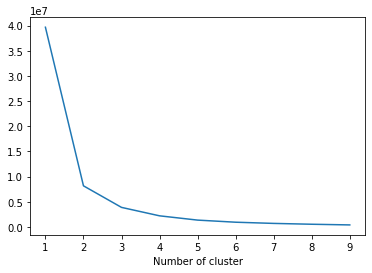

In [19]:
from sklearn.cluster import KMeans
sse={}
recency = user[['Recency']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Here it looks like 3 is the optimal one. Based on business requirements, we can go ahead with less or more clusters. We will be selecting 4 for this example:

In [20]:
#build 4 clusters for recency and add it to dataframe

kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Recency']])
user['RecencyCluster'] = kmeans.predict(user[['Recency']])

#function for ordering cluster numbers

def order_cluster(cluster_field_name, target_field_name,data,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    data_new = data.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    data_new = data_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    data_new['index'] = data_new.index
    data_final = pd.merge(data,data_new[[cluster_field_name,'index']], on=cluster_field_name)
    data_final = data_final.drop([cluster_field_name],axis=1)
    data_final = data_final.rename(columns={"index":cluster_field_name})

    return data_final

user = order_cluster('RecencyCluster', 'Recency',user,False)
user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,0
1,15100.0,329,0
2,18074.0,373,0
3,16250.0,260,0
4,13747.0,373,0


In [21]:
#k-means

kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Recency']])
user['RecencyCluster'] = kmeans.predict(user[['Recency']])

#order the recency cluster
user = order_cluster('RecencyCluster', 'Recency',user,True)

#see details of each cluster
user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0
1,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
2,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
3,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0


### Frequency
To create frequency clusters, we need to find total number orders for each customer. First calculate this and see how frequency look like in our customer database:

In [22]:
#get order counts for each user and create a dataframe with it
frequency = uk.groupby('CustomerID').InvoiceDate.count().reset_index()
frequency.columns = ['CustomerID','Frequency']

#add this data to our main dataframe
user = pd.merge(user, frequency, on='CustomerID')
user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,3,312
1,15100.0,329,3,6
2,18074.0,373,3,13
3,16250.0,260,3,24
4,13747.0,373,3,1


In [23]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Frequency']])
user['FrequencyCluster'] = kmeans.predict(user[['Frequency']])

#order the recency cluster
user = order_cluster('FrequencyCluster', 'Frequency',user,True)

#see details of each cluster
user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0


As the same notation as recency clusters, high frequency number indicates better customers.
### Monetary
Let’s see how our customer database looks like when we cluster them based on monetary value. We will calculate monetary value for each customer.

In [24]:
#calculate revenue for each customer
uk['Monetary'] = uk['Price'] * uk['Quantity']
monetary = uk.groupby('CustomerID').Monetary.sum().reset_index()

#merge it with our main dataframe
user = pd.merge(user, monetary, on='CustomerID')
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary
0,17850.0,301,3,312,1,5288.63
1,15808.0,305,3,210,1,3724.77
2,13047.0,31,0,196,1,3079.10
3,14688.0,7,0,359,1,5107.38
4,16029.0,38,0,274,1,50992.61


In [25]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Monetary']])
user['MonetaryCluster'] = kmeans.predict(user[['Monetary']])

#order the cluster numbers
user = order_cluster('MonetaryCluster', 'Monetary',user,True)

#show details of the dataframe
user.groupby('MonetaryCluster')['Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetaryCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


We have some customers with negative revenue as well. 
## Overall Score
We have scores (cluster numbers) for recency, frequency & revenue. Let’s create an overall score out of them:

In [26]:
#calculate overall score and use mean() to see details
user['OverallScore'] = user['RecencyCluster'] + user['FrequencyCluster'] + user['MonetaryCluster']
user.groupby('OverallScore')['Recency','Frequency','Monetary'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Recency,Frequency,Monetary
OverallScore,,,
0,19.223657,64.579878,1031.923869
1,62.308970,100.122924,1494.764885
2,144.259705,109.124498,2339.267819
3,284.768482,72.778210,1609.635136
4,83.900000,934.400000,74360.852000
5,76.250000,4516.250000,32955.605000


Let's name these scores:
- 0 to 2: Low Value
- 3 to 4: Mid Value
- 5+: High Value



In [27]:
user['Segment'] = 'Low-Value'
user.loc[user['OverallScore'] > 2,'Segment'] = 'Mid-Value' 
user.loc[user['OverallScore'] > 4,'Segment'] = 'High-Value' 
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,OverallScore,Segment
0,17850.0,301,3,312,1,5288.63,1,5,High-Value
1,14688.0,7,0,359,1,5107.38,1,2,Low-Value
2,13767.0,1,0,399,1,16945.71,1,2,Low-Value
3,15513.0,30,0,314,1,14520.08,1,2,Low-Value
4,14849.0,21,0,392,1,7904.28,1,2,Low-Value


In [28]:
user.describe()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,OverallScore
count,3950.000000,3950.000000,3950.000000,3950.000000,3950.000000,3950.000000,3950.000000,3950.000000
mean,15562.029367,90.778481,0.892152,91.614684,0.122025,1713.385669,0.074430,1.088608
std,1576.848325,100.230349,1.053645,220.557389,0.350517,6548.608224,0.292611,1.055198
min,12346.000000,0.000000,0.000000,1.000000,0.000000,-4287.630000,0.000000,0.000000
25%,14208.250000,16.000000,0.000000,17.000000,0.000000,282.255000,0.000000,0.000000
50%,15571.500000,49.000000,1.000000,41.000000,0.000000,627.060000,0.000000,1.000000
75%,16913.750000,142.000000,2.000000,101.000000,0.000000,1521.782500,0.000000,2.000000
max,18287.000000,373.000000,3.000000,7983.000000,3.000000,256438.490000,3.000000,5.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

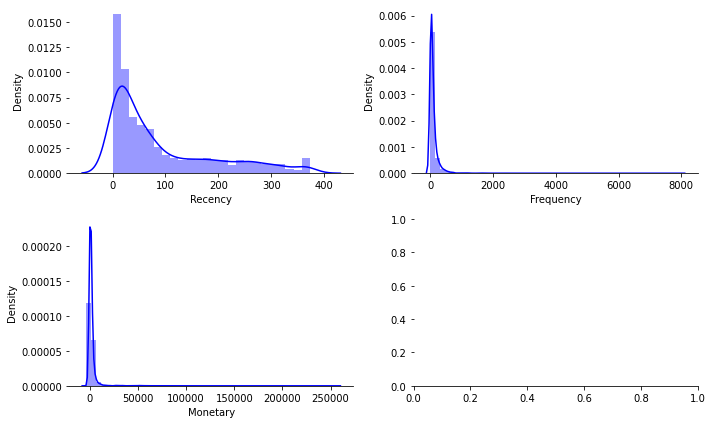

In [29]:
# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(10, 6))
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(user.Recency, color="b", ax=axes[0, 0])
sns.distplot(user.Frequency, color="b", ax=axes[0, 1])
sns.distplot(user.Monetary, color="b",ax=axes[1, 0])

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


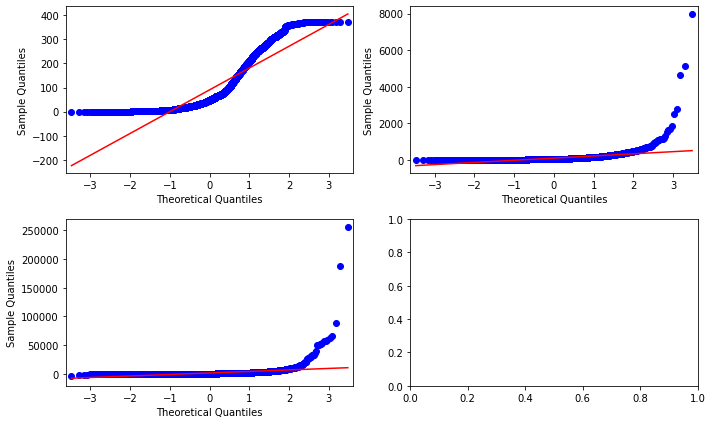

In [30]:
from statsmodels.graphics.gofplots import qqplot

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(10, 6))

# Plot a simple histogram with binsize determined automatically
qqplot(user.Recency, line= 'r', ax=axes[0, 0], label='Recency')
qqplot(user.Frequency, line= 'r',label='Frequency', ax=axes[0, 1])
qqplot(user.Monetary, line= 'r',label='Monetary',ax=axes[1, 0])

#plt.setp(axes, yticks=[])
plt.tight_layout()

In [31]:
print('Skewness (Recency): %f' % user.Recency.skew())
print('*'*60)
print('Kurtosis (Recency): %f' % user.Recency.kurt())
print('*'*60)
print('Skewness (Frequency): %f' % user.Frequency.skew())
print('*'*60)
print('Kurtosis (Frequency): %f' % user.Frequency.kurt())
print('*'*60)
print('Skewness (Monetary): %f' % user.Monetary.skew())
print('*'*60)
print('Kurtosis (Monetary): %f' % user.Monetary.kurt())
print('*'*60)

Skewness (Recency): 1.249520
************************************************************
Kurtosis (Recency): 0.444591
************************************************************
Skewness (Frequency): 18.649754
************************************************************
Kurtosis (Frequency): 541.728117
************************************************************
Skewness (Monetary): 23.346235
************************************************************
Kurtosis (Monetary): 765.039442
************************************************************


In [32]:
from scipy import stats
stats.jarque_bera(user.Recency)

(1059.3034784707156, 0.0)

In [33]:
stats.jarque_bera(user.Frequency)

(48406538.833844736, 0.0)

In [34]:
stats.jarque_bera(user.Monetary)

(96442753.15453245, 0.0)

In [35]:
from scipy.stats import kruskal

# compare samples
stat, p = kruskal(user.Recency, user.Frequency, user.Monetary)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=5929.116, p=0.000
Different distributions (reject H0)


We can start taking actions with this segmentation. The main strategies are quite clear:
- High Value: Improve Retention
- Mid Value: Improve Retention + Increase Frequency
- Low Value: Increase Frequency

## Customer Lifetime Value

Calculating Lifetime Value is the easy part. First we need to select a time window. It can be anything like 3, 6, 12, 24 months. By the equation below, we can have Lifetime Value for each customer in that specific time window:

Lifetime Value: Total Gross Revenue - Total Cost

If we see some customers having very high negative lifetime value historically, it could be too late to take an action. At this point, we need to predict the future with ML algo.

### Lifetime Value Prediction
We will continue using our online retail dataset for this example as well. 
- Define an appropriate time frame for CLTV calculation
- Identify the features we are for training theML model
- Build and run the machine learning model
- Check if the model is useful

We know the RFM scores for each customer ID. To implement it correctly, we need to split our dataset. We will take 3 months of data, calculate RFM and use it for predicting next 6 months. So we need to create two dataframes first and append RFM scores to them.

In [36]:
#import libraries

from datetime import datetime, timedelta,date
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans

In [37]:
DF = pd.read_excel("Online Retail (1).xlsx")
DF.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [45]:
DF['InvoiceDate'] = pd.to_datetime(DF['InvoiceDate'])
DF_uk = DF.query("Country=='United Kingdom'").reset_index(drop=True)

In [53]:
date(2007,12,5)

datetime.date(2007, 12, 5)

In [50]:
import datetime as dt

In [51]:
#create 3m and 6m dataframes
m3 = DF[(DF.InvoiceDate < dt.datetime(2011,6,1)) & (DF.InvoiceDate >= dt.datetime(2011,3,1))].reset_index(drop=True)
m6 = DF[(DF.InvoiceDate >= dt.datetime(2011,6,1)) & (DF.InvoiceDate < dt.datetime(2011,12,1))].reset_index(drop=True)

In [52]:
#create DF_user for assigning clustering
DF_user = pd.DataFrame(m3['CustomerID'].unique())
DF_user.columns = ['CustomerID']

In [54]:
#order cluster method
def order_cluster(cluster_field_name, target_field_name,DF,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    DF_new = DF.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    DF_new = DF_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    DF_new['index'] = DF_new.index
    DF_final = pd.merge(DF,DF_new[[cluster_field_name,'index']], on=cluster_field_name)
    DF_final = DF_final.drop([cluster_field_name],axis=1)
    DF_final = DF_final.rename(columns={"index":cluster_field_name})

    return DF_final

In [55]:
#calculate recency score
max_purchase = m3.groupby('CustomerID').InvoiceDate.max().reset_index()
max_purchase.columns = ['CustomerID','MaxPurchaseDate']
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days
DF_user = pd.merge(DF_user, max_purchase[['CustomerID','Recency']], on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(DF_user[['Recency']])
DF_user['RecencyCluster'] = kmeans.predict(DF_user[['Recency']])
DF_user = order_cluster('RecencyCluster', 'Recency',DF_user,False)

In [56]:
#calcuate frequency score

Frequency = m3.groupby('CustomerID').InvoiceDate.count().reset_index()
Frequency.columns = ['CustomerID','Frequency']
DF_user = pd.merge(DF_user, Frequency, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(DF_user[['Frequency']])
DF_user['FrequencyCluster'] = kmeans.predict(DF_user[['Frequency']])
DF_user = order_cluster('FrequencyCluster', 'Frequency',DF_user,True)

In [58]:
#calcuate revenue score
m3['Monetary'] = m3['Price'] * m3['Quantity']
Revenue = m3.groupby('CustomerID').Monetary.sum().reset_index()
DF_user = pd.merge(DF_user, Revenue, on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(DF_user[['Monetary']])
DF_user['MonetaryCluster'] = kmeans.predict(DF_user[['Monetary']])
DF_user = order_cluster('MonetaryCluster', 'Monetary',DF_user,True)

In [59]:
#overall scoring
DF_user['OverallScore'] = DF_user['RecencyCluster'] + DF_user['FrequencyCluster'] + DF_user['MonetaryCluster']
DF_user['Segment'] = 'Low-Value'
DF_user.loc[DF_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
DF_user.loc[DF_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [60]:
DF_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,OverallScore,Segment
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value


I won’t be repeating and go over the details of RFM scoring. Since we features, let’s calculate 6 months CLTV for each customer which we are going to use for training our model.

There is no cost specified in the dataset. That’s why Monetary becomes our CLTV directly.

In [62]:
#calculate revenue and create a new dataframe for it
m6['Monetary'] = m6['Price'] * m6['Quantity']
DF_user_6m = m6.groupby('CustomerID')['Monetary'].sum().reset_index()
DF_user_6m.columns = ['CustomerID','m6_Monetary']

Let's merge our 3 months and 6 months dataframes to see correlations between CLTV and the feature set we have.

In [63]:
DF_merge = pd.merge(DF_user, DF_user_6m, on='CustomerID', how='left')
DF_merge =DF_merge.fillna(0)

In [64]:
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

corr= DF_merge.corr(method='pearson') # correlation (pearson)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,OverallScore,m6_Monetary
CustomerID,1.00,-0.00,0.01,-0.02,-0.00,-0.03,-0.05,-0.00,0.00
Recency,-0.00,1.00,-0.97,-0.23,-0.23,-0.20,-0.20,-0.89,-0.13
RecencyCluster,0.01,-0.97,1.00,0.23,0.22,0.20,0.21,0.92,0.14
Frequency,-0.02,-0.23,0.23,1.00,0.77,0.42,0.44,0.49,0.33
FrequencyCluster,-0.00,-0.23,0.22,0.77,1.00,0.37,0.43,0.55,0.26
Monetary,-0.03,-0.20,0.20,0.42,0.37,1.00,0.78,0.43,0.88
MonetaryCluster,-0.05,-0.20,0.21,0.44,0.43,0.78,1.00,0.50,0.62
OverallScore,-0.00,-0.89,0.92,0.49,0.55,0.43,0.50,1.00,0.32
m6_Monetary,0.00,-0.13,0.14,0.33,0.26,0.88,0.62,0.32,1.00


In [65]:
DF_merge.corr()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,OverallScore,m6_Monetary
CustomerID,1.000000,-0.004189,0.009640,-0.024829,-0.004988,-0.033412,-0.045297,-0.003498,0.002763
Recency,-0.004189,1.000000,-0.965711,-0.230261,-0.230210,-0.196027,-0.204095,-0.889504,-0.134293
RecencyCluster,0.009640,-0.965711,1.000000,0.225571,0.224093,0.199569,0.207101,0.916310,0.140207
Frequency,-0.024829,-0.230261,0.225571,1.000000,0.766575,0.419794,0.437871,0.485377,0.329358
FrequencyCluster,-0.004988,-0.230210,0.224093,0.766575,1.000000,0.373009,0.429039,0.545024,0.256602
Monetary,-0.033412,-0.196027,0.199569,0.419794,0.373009,1.000000,0.783878,0.434586,0.881669
MonetaryCluster,-0.045297,-0.204095,0.207101,0.437871,0.429039,0.783878,1.000000,0.503325,0.618207
OverallScore,-0.003498,-0.889504,0.916310,0.485377,0.545024,0.434586,0.503325,1.000000,0.318704
m6_Monetary,0.002763,-0.134293,0.140207,0.329358,0.256602,0.881669,0.618207,0.318704,1.000000


We want LTV clusters. Because it makes it more actionable and easy to communicate with other people. By applying K-means clustering, we can identify our existing LTV groups and build segments on top of it.

Considering business part of this analysis, we need to treat customers differently based on their predicted LTV. For this example, we will apply clustering and have 3 segments (number of segments really depends on your business dynamics and goals):
- Low LTV
- Mid LTV
- High LTV

We are going to apply K-means clustering to decide segments and observe their characteristics:

In [66]:
#remove outliers
DF_merge = DF_merge[DF_merge['m6_Monetary'] < DF_merge['m6_Monetary'].quantile(0.99)]

#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(DF_merge[['m6_Monetary']])
DF_merge['LTVCluster'] = kmeans.predict(DF_merge[['m6_Monetary']])

#order cluster number based on LTV
DF_merge = order_cluster('LTVCluster', 'm6_Monetary',DF_merge,True)

#creatinga new cluster dataframe
DF_cluster = DF_merge.copy()

#see details of the clusters
DF_cluster.groupby('LTVCluster')['m6_Monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1724.0,572.224670,610.253082,-609.40,0.0000,370.805,951.4375,2195.62
1,256.0,3815.228711,1430.791714,2199.38,2686.2725,3439.235,4431.7575,7946.90
2,26.0,12377.135000,3210.865481,8439.09,9607.3225,11861.385,13745.0575,19289.53


2 is the best with average 8.2k LTV whereas 0 is the worst with 396.
There are few more step before training the machine learning model:
- Need to do some feature engineering. We should convert categorical columns to numerical columns.
- We will check the correlation of features against our label, LTV clusters.
- We will split our feature set and label (LTV) as X and y. We use X to predict y.
- Will create Training and Test dataset. Training set will be used for building the machine learning model. 

We will apply our model to Test set to see its real performance.

In [67]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
#convert categorical columns to numerical
DF_class = pd.get_dummies(DF_cluster)

#calculate and show correlations
corr_matrix = DF_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

#create X and y, X will be feature set and y is the label - LTV
X = DF_class.drop(['LTVCluster','m6_Monetary'],axis=1)
y = DF_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

Let’s start with the first line. get_dummies() method converts categorical columns to 0–1 notations. See what it exactly does with the example:

In [68]:
DF_cluster.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,OverallScore,Segment,m6_Monetary,LTVCluster
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00,0
1,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54,0
2,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75,0
3,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04,0
4,12679.0,13,3,47,0,869.13,0,3,Mid-Value,189.54,0


This was our dataset before get_dummies(). We have one categorical column which is Segment. What happens after applying get_dummies():

In [69]:
DF_class = pd.get_dummies(DF_cluster)
DF_class.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,OverallScore,m6_Monetary,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,14620.0,12,3,30,0,393.28,0,3,0.00,0,0,0,1
1,18044.0,5,3,57,0,808.96,0,3,991.54,0,0,0,1
2,18075.0,12,3,35,0,638.12,0,3,1322.75,0,0,0,1
3,15241.0,0,3,64,0,947.55,0,3,791.04,0,0,0,1
4,12679.0,13,3,47,0,869.13,0,3,189.54,0,0,0,1


Segment column is gone but we have new numerical ones which represent it. We have converted it to 3 different columns with 0 and 1 and made it usable for our machine learning model.
Lines related to correlation make us have the data below:

In [70]:
corr_matrix= DF_class.corr(method='pearson') # correlation (pearson)
corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,OverallScore,m6_Monetary,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
CustomerID,1.00,-0.00,0.01,-0.04,-0.00,-0.09,-0.06,-0.01,-0.08,-0.09,-0.06,0.01,0.01
Recency,-0.00,1.00,-0.97,-0.26,-0.22,-0.29,-0.19,-0.90,-0.23,-0.21,-0.19,0.73,-0.68
RecencyCluster,0.01,-0.97,1.00,0.25,0.22,0.29,0.19,0.93,0.23,0.21,0.20,-0.81,0.75
Frequency,-0.04,-0.26,0.25,1.00,0.78,0.50,0.40,0.49,0.40,0.36,0.49,-0.34,0.17
FrequencyCluster,-0.00,-0.22,0.22,0.78,1.00,0.45,0.38,0.51,0.38,0.36,0.49,-0.36,0.19
Monetary,-0.09,-0.29,0.29,0.50,0.45,1.00,0.80,0.51,0.72,0.60,0.54,-0.37,0.18
MonetaryCluster,-0.06,-0.19,0.19,0.40,0.38,0.80,1.00,0.44,0.60,0.51,0.70,-0.28,0.03
OverallScore,-0.01,-0.90,0.93,0.49,0.51,0.51,0.44,1.00,0.40,0.36,0.43,-0.82,0.69
m6_Monetary,-0.08,-0.23,0.23,0.40,0.38,0.72,0.60,0.40,1.00,0.85,0.46,-0.27,0.11
LTVCluster,-0.09,-0.21,0.21,0.36,0.36,0.60,0.51,0.36,0.85,1.00,0.41,-0.26,0.12


In [71]:
#corr_matrix = DF_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Monetary           0.852419
Monetary              0.595305
MonetaryCluster       0.512696
Segment_High-Value    0.407606
Frequency             0.363203
OverallScore          0.363057
FrequencyCluster      0.357739
RecencyCluster        0.208669
Segment_Mid-Value     0.116876
CustomerID           -0.090203
Recency              -0.206322
Segment_Low-Value    -0.256989
Name: LTVCluster, dtype: float64

We see that 3 months Revenue, Frequency and RFM scores will be helpful for our machine learning models.

With the training and test sets we can build our model.

In [72]:
X.head(2)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Monetary,MonetaryCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,14620.0,12,3,30,0,393.28,0,3,0,0,1
1,18044.0,5,3,57,0,808.96,0,3,0,0,1


## Algorithm comparison

In [74]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import model_selection
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

xgb = xgb.XGBClassifier()
logreg2= LogisticRegressionCV()
knn = KNeighborsClassifier()
svcl = SVC()
adb = AdaBoostClassifier()
dtclf = DecisionTreeClassifier()
rfclf = RandomForestClassifier()

# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('LR', LogisticRegressionCV(solver='lbfgs', max_iter=5000, cv=5, multi_class='auto')))
models.append(('XGB', XGBClassifier()))
models.append(('KNN', KNeighborsClassifier(5)))
models.append(('DT', DecisionTreeClassifier(max_depth=5)))
models.append(('RF', RandomForestClassifier(n_estimators=100)))
models.append(('ADA', AdaBoostClassifier()))
models.append(('SVC', SVC(gamma='scale')))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=None)
    cv_results = model_selection.cross_val_score(model,X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.880315 (0.020236)
XGB: 0.869816 (0.012378)
KNN: 0.851969 (0.012598)
DT: 0.865092 (0.015800)
RF: 0.866667 (0.019599)
ADA: 0.822047 (0.037941)
SVC: 0.862467 (0.013749)


### XGB model

In [75]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
from datetime import datetime, timedelta,date

#XGBoost Multiclassification Model
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('*'*60)

print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))
print('*'*60)

y_pred = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.95
************************************************************
Accuracy of XGB classifier on test set: 0.88
************************************************************
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        87
           1       0.50      0.33      0.40        12
           2       1.00      0.50      0.67         2

    accuracy                           0.88       101
   macro avg       0.80      0.60      0.67       101
weighted avg       0.87      0.88      0.87       101



#### We have a multi classification model with 3 groups (clusters).

Precision and recall are acceptable for 0. As an example, for cluster 0 (Low CLTV), if model tells us this customer belongs to cluster 0, 90 out of 100 will be correct (precision). And the model successfully identifies 93% of actual cluster 0 customers (recall). We really need to improve the model for other clusters. For example, we barely detect 56% of Mid CLTV customers. Possible actions to improve those points:
- Adding more features and improve feature engineering
- Apply hyper parameter tuning to current model
- Try neural network/deep learning models

Here ML model can predict the future CLTV segments of the customers. We can easily adapt our actions based on that. 

In [76]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer

clf = OneVsRestClassifier(XGBClassifier(n_jobs=-1, max_depth=4, learning_rate=0.1))
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=XGBClassifier(max_depth=4, n_jobs=-1))

In [77]:
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(clf.score(X_train, y_train)))
print('*'*60)

print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(clf.score(X_test[X_train.columns], y_test)))
print('*'*60)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

Accuracy of XGB classifier on training set: 0.93
************************************************************
Accuracy of XGB classifier on test set: 0.89
************************************************************
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        87
           1       0.57      0.33      0.42        12
           2       1.00      0.50      0.67         2

    accuracy                           0.89       101
   macro avg       0.83      0.60      0.68       101
weighted avg       0.87      0.89      0.88       101



In [78]:
pip install yellowbrick

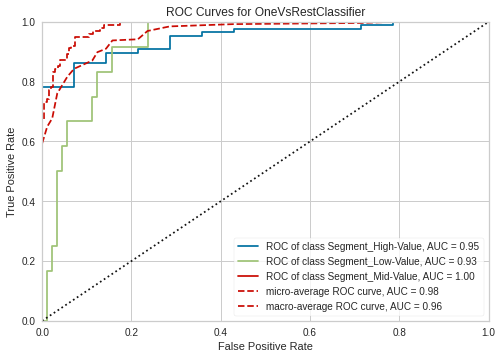

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7efdbe756310>,
       classes=['Segment_High-Value', 'Segment_Low-Value', 'Segment_Mid-Value'],
       estimator=OneVsRestClassifier(estimator=XGBClassifier(max_depth=4,
                                                             n_jobs=-1)))

In [79]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(clf, classes=["Segment_High-Value",	"Segment_Low-Value","Segment_Mid-Value"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof()
visualizer

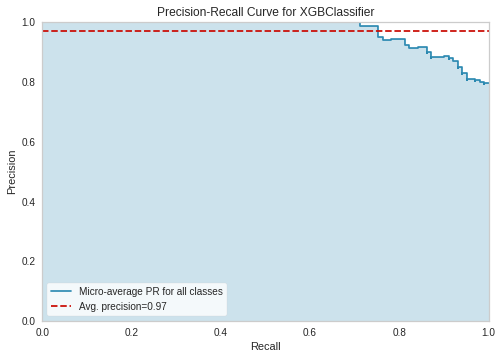

In [80]:
from yellowbrick.classifier import PrecisionRecallCurve
# Create the visualizer, fit, score, and poof it
viz = PrecisionRecallCurve(XGBClassifier())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

### Class Prediction Error
The class prediction error chart provides a way to quickly understand how good the classifier is at predicting the right classes.

Like the Classification Report, this plot shows the support (number of training samples) for each class in the fitted classification model as a stacked bar chart. Each bar is segmented to show the proportion of predictions (including false negatives and false positives) for each class. We have used a ClassPredictionError to visualize which classes our classifier is having a particularly difficult time with, and more importantly, what incorrect answers it is giving on a per-class basis. 
The class prediction error chart provides a way to quickly understand how good your classifier is at predicting the right classes.

In [86]:
from yellowbrick.classifier import ClassPredictionError
# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    XGBClassifier(random_state=42), classes=["Segment_High-Value",	"Segment_Low-Value","Segment_Mid-Value"]
)



In [89]:
# Fit the training data to the visualizer
fit = visualizer.fit(X_train, y_train)

In [90]:
# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.poof()

XGBoostError: ignored

XGBClassifier is correrectly predicting Segment_High_Value, sometime it incorrectly labels Segment_Low_value as Segment_High_Value and mistakes Segment_Mid_Value to Low_Value_Value but that is very few cases.